In [1]:
%load_ext autoreload
%autoreload 2

from darts.datasets import ETTh1Dataset
from darts.models import NLinearModel
from darts.metrics.metrics import mae, mse
import numpy as np
import pandas as pd
import torch
import random
import csv
import datetime
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torchmetrics.regression import MeanAbsoluteError, MeanSquaredError
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_timeline

import models
import models_3d_concepts_on_time
import models_3d_atomics_on_variate_to_concepts
from preprocess_helpers import *
from helper import *
from param_initializations import *
from optimization_strategy import greedy_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

[[-95. ]
 [-94.9]
 [-94.8]
 ...
 [104.7]
 [104.8]
 [104.9]]


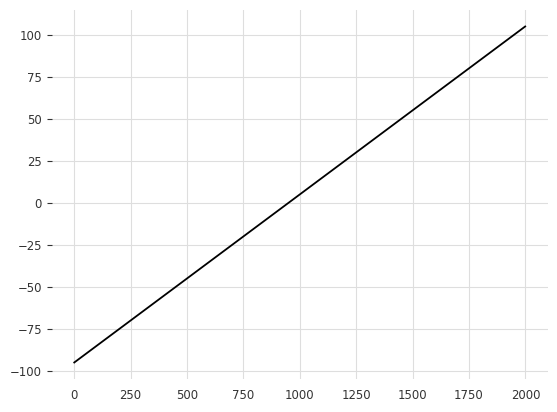

In [29]:

def line(x, w=0.1, b=5):
    return w*x + b

time = list(range(-1000, 1000))
series = [line(x) for x in time]
series = np.array(series).reshape(-1,1)
print(series)
plt.plot(series)
plt.show()

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, T, window_stride=1, pred_len=1):
        self.data = data
        self.targets = targets
        assert targets.size(0) == data.size(0)
        self.T = T # time window
        self.window_stride = window_stride
        self.pred_len = pred_len
        self.N, self.V = data.shape

    def __len__(self):
        return len(range(0, self.N - self.T - self.pred_len + 1, self.window_stride))

    def __getitem__(self, idx):
        start = idx * self.window_stride
        end = start + self.T

        X = self.data[start:end]
        # if mode == "S": # predict only target
        y = self.targets[end:end + self.pred_len].flatten()
        # elif mode == "MS": # predict all variables
        #   y = self.data[end:end + self.pred_len, :7].flatten()
        return X, y


In [18]:
def preprocess_data(series, seq_len, window_stride=1, pred_len=1, batch_size = 512):
    scaler = StandardScaler()
    
    train_end = int(len(series) * 0.6)
    val_end = int(train_end + len(series) * 0.2)
    
    train = series[:train_end]
    val = series[train_end:val_end]
    test = series[val_end:]
    
    # train, test = series.split_before(0.6)
    # val, test = test.split_before(0.5)
    
    print("Train/Val/Test", len(train), len(val), len(test))
    
    train = scaler.fit_transform(train)
    X_train = pd.DataFrame(train)
    y_train = X_train
    X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_train)
    X_train = torch.cat([X_train, indicators], axis=1)
    
    train_dataset = TimeSeriesDataset(X_train, y_train, seq_len, window_stride, pred_len)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)

    val = scaler.transform(val)
    X_val = pd.DataFrame(val)
    y_val = X_val
    X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
    y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_val)
    X_val = torch.cat([X_val, indicators], axis=1)
    
    val_dataset = TimeSeriesDataset(X_val, y_val, seq_len, window_stride, pred_len)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)

    test = scaler.transform(test)
    X_test = pd.DataFrame(test)
    y_test = X_test
    X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_test)
    X_test = torch.cat([X_test, indicators], axis=1)
    
    test_dataset = TimeSeriesDataset(X_test, y_test, seq_len, window_stride, pred_len)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader, scaler


Train/Val/Test 1200 400 400


torch.Size([512, 100, 2])
torch.Size([512, 10])


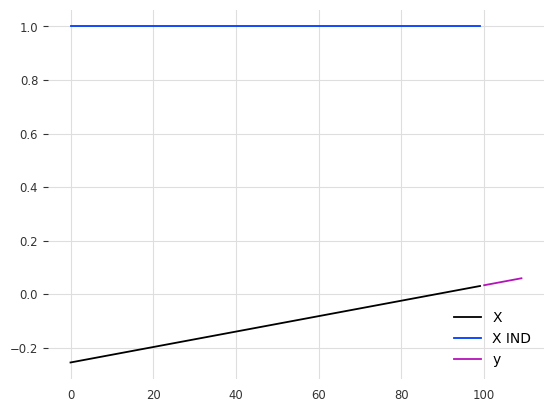

Batches 3 1 1


In [41]:
seq_len = 100
pred_len = 10

train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

for X,y in train_loader:
    print(X.shape)
    print(y.shape)
    break

i = 511
plt.plot(range(seq_len), X[i, :, 0], label="X")
plt.plot(range(seq_len), X[i, :, 1], label="X IND")
plt.plot(range(seq_len, seq_len + pred_len), y[i], label="y")
plt.legend()
plt.show()


print("Batches", len(train_loader), len(val_loader), len(test_loader))


In [20]:
# plots
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.legend()
    plt.show()

def plot_mae_mse(history, title, dec="{:.3g}"):
    xticks = range(len(history[:, 0]))
    plt.plot(xticks, history[:, 2], label='MAE')
    plt.plot(xticks, history[:, 3], label='MSE')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    # plt.ylim(0, 1)
    xtick_labels = list(map(int, history[:, 0]))
    plt.xticks(xticks, xtick_labels)
    plt.yscale('log')

    if dec:
        for x,_y in zip(xticks, history[:, 2]):
            label = dec.format(_y)
            plt.annotate(label, # this is the text
                        (x,_y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,-10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center
            
        for x,_y in zip(xticks, history[:, 3]):
            label = dec.format(_y)
            plt.annotate(label, # this is the text
                        (x,_y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,-10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center

    plt.title(title)
    plt.legend()
    plt.show()


def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "mae", "mse"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["mae"], label='MAE')
    plt.plot(mean_atomics.index, mean_atomics["mse"], label='MSE')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["mae"], label='MAE')
    plt.plot(mean_concepts.index, mean_concepts["mse"], label='MSE')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()
    

def plot_prediction_vs_true(yb, preds, title):
    plt.plot(yb, color="black", label="True")
    plt.plot(preds, color="red", label="Pred")
    plt.title(title)
    plt.legend()
    plt.show()


In [ ]:
def initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim, top_k=''):
    model = models.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            opt_lr = 3e-3, # 2e-4
                            opt_weight_decay = 1e-05,
                            l1_lambda=0,#0.001,
                            cos_sim_lambda=0,#0.01,
                            output_dim = output_dim,
                            top_k=top_k,
                            task_type=models.TaskType.REGRESSION,
                            )
    model = model.to(device)
    return model

def initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim, use_summaries_for_atomics, top_k=''):
    model = models_3d_atomics_on_variate_to_concepts.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            num_atomics = n_atomics,
                            use_summaries_for_atomics = use_summaries_for_atomics,
                            opt_lr = 3e-3, # 2e-4
                            opt_weight_decay = 1e-05,
                            l1_lambda=0,#0.001,
                            cos_sim_lambda=0,#0.01,
                            output_dim = output_dim,
                            top_k=top_k,
                            task_type=models_3d_atomics_on_variate_to_concepts.TaskType.REGRESSION,
                            )
    model = model.to(device)
    return model

In [22]:
random_seed = 1
set_seed(random_seed)


In [26]:
seq_len = 100
pred_len = 10
n_atomics_list = list(range(2,11,2))
n_concepts_list = list(range(2,11,2))
changing_dim = 1 #len(series.columns)
input_dim = 2 * changing_dim


## Blaaa

In [45]:
experiment_folder = f"/workdir/optimal-summaries-public/vasopressor/models/etth1/debugging-L{seq_len}-T{pred_len}/"
# model_path_re = experiment_folder + "forecasting_c{}_a{}.pt"
model_path_re = experiment_folder + "forecasting_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [46]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

n_concepts = 10
n_atomics = 10

# model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True)
model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=5) 

# model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts, n_atomics), max_epochs=10000, scheduler=scheduler)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts), max_epochs=10000, scheduler=scheduler)


model.eval()
with torch.no_grad():
    # for batch_idx, (Xb, yb) in enumerate(train_loader):
    #     Xb, yb = Xb.to(device), yb.to(device)
    #     preds = model(Xb)
        
    #     mae = mae_metric(preds, yb).item()
    #     mse = mse_metric(preds, yb).item()
    # mae = mae_metric.compute().item()
    # mse = mse_metric.compute().item()
    # mae_metric.reset()
    # mse_metric.reset()

    # print("MSE", mse, "MAE", mae)


    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        break


i = 20
yb = yb.cpu().numpy()[i].reshape(-1, 1)
preds = preds.cpu().numpy()[i].reshape(-1, 1)

print(yb.shape)
print(preds.shape)

plot_prediction_vs_true(yb, preds, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(yb.flatten(), preds.flatten()))


ybs = scaler.inverse_transform(yb)
predss = scaler.inverse_transform(preds)

plot_prediction_vs_true(ybs, predss, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(ybs.flatten(), predss.flatten()))


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Train/Val/Test 1200 400 400


  0%|          | 0/10000 [00:00<?, ?it/s]

 47%|████▋     | 4667/10000 [18:14<20:16,  4.38it/s]